# Dog Heart Vertebral Heart Size Point Detection 

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Object detection model using pytorch

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,models
from torchvision import transforms as T
import torch.optim as optim

import os
import cv2
from PIL import Image

import pandas as pd
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

class PointDetectionModel(nn.Module):
    def __init__(self, num_points=6):
        super(PointDetectionModel, self).__init__()
        self.backbone = models.efficientnet_b7(pretrained=True)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Linear(in_features, num_points * 2)

    def forward(self, x):
        x = self.backbone(x)
        return x

num_points = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointDetectionModel(num_points).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 226MB/s]


# Dataloader for Model Training

In [11]:
class DogHeartDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        #print('w and h of orig', w, h)
        #print('original size', img.size)
        #print('before transfe')
        if self.transforms is not None:
            img = self.transforms(img)
            #print('aletr size', img.shape)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        #print('six points before normal', six_points)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        #print('zero column', six_points[:,0])
        six_points[:,0] = w_new/w*six_points[:,0] # Resize image to any size and maintain original points
        six_points[:,1] = h_new/h*six_points[:,1]
        #print('after renormalize', six_points[:,0]/h_new)
        six_points = torch.reshape(six_points, (-1,))/h_new # Normlize the points
        VHS = mat['VHS'].astype(float)
        #print('VHS before load', VHS)
        VHS  = torch.as_tensor(VHS, dtype=torch.float32)
        #target = {'points' : torch.tensor(six_points, dtype=torch.float32)}
        #target = {'points': torch.tensor(coords, dtype=torch.float32)}
        #six_points = torch.tensor(six_points, dtype=torch.float32)
        return img,six_points,self.imgs[idx]# six_points, VHS


    def __len__(self):
        return len(self.imgs)


def get_transform(resized_image_size):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size = (resized_image_size,resized_image_size)))
    transforms.append(T.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]))
    return T.Compose(transforms)


## Read Train dataset using the dataloader
resized_image_size = 512
batch_size = 8
dataset_train = DogHeartDataset('/content/drive/MyDrive/Train_project2', get_transform(resized_image_size))
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = DogHeartDataset('/content/drive/MyDrive/Valid_project2', get_transform(resized_image_size))
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


# Model Training

In [ ]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        if isinstance(outputs, tuple):
          outputs = outputs[0]  # Use only the primary output for loss calculation
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [22:09<00:00,  7.60s/it]


Epoch 1/60, Training Loss: 0.0162


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 2/60, Training Loss: 0.0017


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 3/60, Training Loss: 0.0013


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 4/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 5/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 6/60, Training Loss: 0.0011


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 7/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 8/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 9/60, Training Loss: 0.0011


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 10/60, Training Loss: 0.0011
Model saved at epoch 10


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch 11/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 12/60, Training Loss: 0.0011


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 13/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 14/60, Training Loss: 0.0011


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 15/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 16/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 17/60, Training Loss: 0.0012


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 18/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 19/60, Training Loss: 0.0012


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 20/60, Training Loss: 0.0010
Model saved at epoch 20


100%|██████████| 175/175 [01:46<00:00,  1.64it/s]


Epoch 21/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 22/60, Training Loss: 0.0011


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 23/60, Training Loss: 0.0011


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 24/60, Training Loss: 0.0012


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 25/60, Training Loss: 0.0012


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 26/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 27/60, Training Loss: 0.0012


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 28/60, Training Loss: 0.0012


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 29/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 30/60, Training Loss: 0.0011
Model saved at epoch 30


100%|██████████| 175/175 [01:46<00:00,  1.64it/s]


Epoch 31/60, Training Loss: 0.0013


100%|██████████| 175/175 [01:46<00:00,  1.64it/s]


Epoch 32/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.64it/s]


Epoch 33/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 34/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:46<00:00,  1.64it/s]


Epoch 35/60, Training Loss: 0.0008


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 36/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 37/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 38/60, Training Loss: 0.0010


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 39/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 40/60, Training Loss: 0.0008
Model saved at epoch 40


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch 41/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 42/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


Epoch 43/60, Training Loss: 0.0009


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


Epoch 44/60, Training Loss: 0.0009


  1%|          | 2/175 [00:01<01:42,  1.68it/s]

In [ ]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
              outputs = outputs[0]  # Use only the primary output for loss calculation
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [42:18<00:00, 14.51s/it]


Epoch 1/20, Training Loss: 0.0009


100%|██████████| 25/25 [05:45<00:00, 13.81s/it]


Epoch 1/20, Validation Loss: 0.001886


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 2/20, Training Loss: 0.0008


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 2/20, Validation Loss: 0.001707


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 3/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Epoch 3/20, Validation Loss: 0.002433


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 4/20, Training Loss: 0.0008


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 4/20, Validation Loss: 0.000924


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 5/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Epoch 5/20, Validation Loss: 0.002016


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 6/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 6/20, Validation Loss: 0.002142


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 7/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 7/20, Validation Loss: 0.002488


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 8/20, Training Loss: 0.0008


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 8/20, Validation Loss: 0.000758


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 9/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 9/20, Validation Loss: 0.001991


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 10/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Epoch 10/20, Validation Loss: 0.001097
Model saved at epoch 10


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 11/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Epoch 11/20, Validation Loss: 0.000737


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 12/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 12/20, Validation Loss: 0.001023


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 13/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 13/20, Validation Loss: 0.000737


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 14/20, Training Loss: 0.0008


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 14/20, Validation Loss: 0.002313


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 15/20, Training Loss: 0.0008


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 15/20, Validation Loss: 0.001605


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 16/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 16/20, Validation Loss: 0.001393


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 17/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 17/20, Validation Loss: 0.001811


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 18/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 18/20, Validation Loss: 0.002227


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 19/20, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 19/20, Validation Loss: 0.001044


100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 20/20, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 20/20, Validation Loss: 0.001851
Model saved at epoch 20
Final model saved


In [ ]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 30
for epoch in range(30,61):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
              outputs = outputs[0]  # Use only the primary output for loss calculation
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 31/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 31/30, Validation Loss: 0.000862


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 32/30, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 32/30, Validation Loss: 0.000742


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 33/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 33/30, Validation Loss: 0.000615


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 34/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 34/30, Validation Loss: 0.000869


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 35/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 35/30, Validation Loss: 0.000992


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 36/30, Training Loss: 0.0007


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 36/30, Validation Loss: 0.000695


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 37/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 37/30, Validation Loss: 0.001057


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 38/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 38/30, Validation Loss: 0.000753


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 39/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 39/30, Validation Loss: 0.000771


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 40/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 40/30, Validation Loss: 0.000661
Model saved at epoch 40


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 41/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 41/30, Validation Loss: 0.000720


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 42/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 42/30, Validation Loss: 0.002112


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 43/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 43/30, Validation Loss: 0.000908


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 44/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 44/30, Validation Loss: 0.000733


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 45/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 45/30, Validation Loss: 0.000351


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 46/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


Epoch 46/30, Validation Loss: 0.000331


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 47/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 47/30, Validation Loss: 0.000334


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 48/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 48/30, Validation Loss: 0.000297


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 49/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 49/30, Validation Loss: 0.000294


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 50/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 50/30, Validation Loss: 0.000328
Model saved at epoch 50


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 51/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 51/30, Validation Loss: 0.000307


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 52/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 52/30, Validation Loss: 0.000326


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 53/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 53/30, Validation Loss: 0.000298


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 54/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 54/30, Validation Loss: 0.000303


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 55/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 55/30, Validation Loss: 0.000323


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 56/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 56/30, Validation Loss: 0.000321


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 57/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 57/30, Validation Loss: 0.000320


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 58/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 58/30, Validation Loss: 0.000351


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 59/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Epoch 59/30, Validation Loss: 0.000326


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 60/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 60/30, Validation Loss: 0.000350
Model saved at epoch 60


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 61/30, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

Epoch 61/30, Validation Loss: 0.000292
Final model saved


In [7]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 30
for epoch in range(60,91):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
              outputs = outputs[0]  # Use only the primary output for loss calculation
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new1_{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [22:44<00:00,  7.80s/it]


Epoch 61/30, Training Loss: 0.0006


100%|██████████| 25/25 [03:00<00:00,  7.24s/it]


Epoch 61/30, Validation Loss: 0.001223


100%|██████████| 175/175 [03:57<00:00,  1.36s/it]


Epoch 62/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 62/30, Validation Loss: 0.001001


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 63/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 63/30, Validation Loss: 0.001266


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 64/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 64/30, Validation Loss: 0.003201


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 65/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 65/30, Validation Loss: 0.000574


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 66/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 66/30, Validation Loss: 0.000841


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 67/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 67/30, Validation Loss: 0.005700


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 68/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 68/30, Validation Loss: 0.000673


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 69/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 69/30, Validation Loss: 0.000734


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 70/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 70/30, Validation Loss: 0.000420
Model saved at epoch 70


100%|██████████| 175/175 [03:59<00:00,  1.37s/it]


Epoch 71/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 71/30, Validation Loss: 0.001040


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 72/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 72/30, Validation Loss: 0.001844


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 73/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 73/30, Validation Loss: 0.000936


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 74/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 74/30, Validation Loss: 0.000677


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 75/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 75/30, Validation Loss: 0.000657


100%|██████████| 175/175 [03:59<00:00,  1.37s/it]


Epoch 76/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Epoch 76/30, Validation Loss: 0.000875


100%|██████████| 175/175 [04:00<00:00,  1.37s/it]


Epoch 77/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Epoch 77/30, Validation Loss: 0.000604


100%|██████████| 175/175 [04:00<00:00,  1.37s/it]


Epoch 78/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 78/30, Validation Loss: 0.001187


100%|██████████| 175/175 [04:00<00:00,  1.37s/it]


Epoch 79/30, Training Loss: 0.0006


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Epoch 79/30, Validation Loss: 0.000845


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 80/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 80/30, Validation Loss: 0.000505
Model saved at epoch 80


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 81/30, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 81/30, Validation Loss: 0.000802


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 82/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 82/30, Validation Loss: 0.000340


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 83/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 83/30, Validation Loss: 0.000305


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 84/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 84/30, Validation Loss: 0.000297


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 85/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 85/30, Validation Loss: 0.000318


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 86/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 86/30, Validation Loss: 0.000293


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 87/30, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 87/30, Validation Loss: 0.000289


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 88/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 88/30, Validation Loss: 0.000307


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 89/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 89/30, Validation Loss: 0.000297


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 90/30, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 90/30, Validation Loss: 0.000315
Model saved at epoch 90


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 91/30, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]

Epoch 91/30, Validation Loss: 0.000296
Final model saved


In [11]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 120
for epoch in range(91,121):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
              outputs = outputs[0]  # Use only the primary output for loss calculation
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new2_{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 92/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 92/120, Validation Loss: 0.000541


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 93/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 93/120, Validation Loss: 0.000691


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 94/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 94/120, Validation Loss: 0.000839


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 95/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 95/120, Validation Loss: 0.000590


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 96/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 96/120, Validation Loss: 0.000771


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 97/120, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 97/120, Validation Loss: 0.001576


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 98/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 98/120, Validation Loss: 0.000423


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 99/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 99/120, Validation Loss: 0.001169


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 100/120, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 100/120, Validation Loss: 0.000449
Model saved at epoch 100


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 101/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 101/120, Validation Loss: 0.000800


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 102/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 102/120, Validation Loss: 0.000817


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 103/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 103/120, Validation Loss: 0.001808


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 104/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 104/120, Validation Loss: 0.000623


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 105/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 105/120, Validation Loss: 0.000508


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 106/120, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 106/120, Validation Loss: 0.000683


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 107/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 107/120, Validation Loss: 0.000957


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 108/120, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 108/120, Validation Loss: 0.000562


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 109/120, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 109/120, Validation Loss: 0.000598


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 110/120, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 110/120, Validation Loss: 0.000316
Model saved at epoch 110


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 111/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 111/120, Validation Loss: 0.000317


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 112/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 112/120, Validation Loss: 0.000302


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 113/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 113/120, Validation Loss: 0.000297


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 114/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 114/120, Validation Loss: 0.000300


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 115/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 115/120, Validation Loss: 0.000304


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 116/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 116/120, Validation Loss: 0.000293


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 117/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 117/120, Validation Loss: 0.000309


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 118/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 118/120, Validation Loss: 0.000296


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 119/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 119/120, Validation Loss: 0.000307


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 120/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 120/120, Validation Loss: 0.000295
Model saved at epoch 120


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 121/120, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]

Epoch 121/120, Validation Loss: 0.000306
Final model saved


In [13]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 150
for epoch in range(121,151):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new2_{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [03:56<00:00,  1.35s/it]


Epoch 122/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 122/150, Validation Loss: 0.000603


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 123/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 123/150, Validation Loss: 0.000462


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 124/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 124/150, Validation Loss: 0.000555


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 125/150, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 125/150, Validation Loss: 0.001059


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 126/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 126/150, Validation Loss: 0.000515


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 127/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 127/150, Validation Loss: 0.000879


100%|██████████| 175/175 [03:57<00:00,  1.36s/it]


Epoch 128/150, Training Loss: 0.0005


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Epoch 128/150, Validation Loss: 0.000536


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 129/150, Training Loss: 0.0005


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Epoch 129/150, Validation Loss: 0.001988


100%|██████████| 175/175 [03:57<00:00,  1.36s/it]


Epoch 130/150, Training Loss: 0.0005


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 130/150, Validation Loss: 0.000482
Model saved at epoch 130


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 131/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 131/150, Validation Loss: 0.000496


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 132/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 132/150, Validation Loss: 0.000573


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 133/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 133/150, Validation Loss: 0.000857


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 134/150, Training Loss: 0.0004


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 134/150, Validation Loss: 0.000537


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 135/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 135/150, Validation Loss: 0.000309


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 136/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 136/150, Validation Loss: 0.000295


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 137/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 137/150, Validation Loss: 0.000307


100%|██████████| 175/175 [03:53<00:00,  1.34s/it]


Epoch 138/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 138/150, Validation Loss: 0.000306


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 139/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 139/150, Validation Loss: 0.000314


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 140/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 140/150, Validation Loss: 0.000298
Model saved at epoch 140


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 141/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 141/150, Validation Loss: 0.000295


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 142/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 142/150, Validation Loss: 0.000307


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 143/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 143/150, Validation Loss: 0.000291


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 144/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 144/150, Validation Loss: 0.000299


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 145/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 145/150, Validation Loss: 0.000296


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 146/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 146/150, Validation Loss: 0.000298


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 147/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 147/150, Validation Loss: 0.000295


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 148/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 148/150, Validation Loss: 0.000301


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 149/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 149/150, Validation Loss: 0.000303


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 150/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 150/150, Validation Loss: 0.000311
Model saved at epoch 150


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 151/150, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]

Epoch 151/150, Validation Loss: 0.000306
Final model saved


In [15]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 180
for epoch in range(121,181):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new3_{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 122/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 122/180, Validation Loss: 0.000332


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 123/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 123/180, Validation Loss: 0.000349


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 124/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 124/180, Validation Loss: 0.000324


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 125/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 125/180, Validation Loss: 0.000325


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 126/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 126/180, Validation Loss: 0.000308


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 127/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 127/180, Validation Loss: 0.000314


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 128/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 128/180, Validation Loss: 0.000360


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 129/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 129/180, Validation Loss: 0.000318


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 130/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 130/180, Validation Loss: 0.000326
Model saved at epoch 130


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 131/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 131/180, Validation Loss: 0.000366


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 132/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 132/180, Validation Loss: 0.000316


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 133/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 133/180, Validation Loss: 0.000370


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 134/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 134/180, Validation Loss: 0.000309


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 135/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 135/180, Validation Loss: 0.000339


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 136/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 136/180, Validation Loss: 0.000356


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 137/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 137/180, Validation Loss: 0.000319


100%|██████████| 175/175 [03:56<00:00,  1.35s/it]


Epoch 138/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 138/180, Validation Loss: 0.000288


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 139/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 139/180, Validation Loss: 0.000292


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 140/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Epoch 140/180, Validation Loss: 0.000289
Model saved at epoch 140


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 141/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 141/180, Validation Loss: 0.000290


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 142/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 142/180, Validation Loss: 0.000289


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 143/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 143/180, Validation Loss: 0.000288


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 144/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 144/180, Validation Loss: 0.000291


100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 145/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 145/180, Validation Loss: 0.000288


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 146/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 146/180, Validation Loss: 0.000291


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 147/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 147/180, Validation Loss: 0.000294


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 148/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 148/180, Validation Loss: 0.000286


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 149/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 149/180, Validation Loss: 0.000294


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 150/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 150/180, Validation Loss: 0.000289
Model saved at epoch 150


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 151/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 151/180, Validation Loss: 0.000293


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 152/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 152/180, Validation Loss: 0.000286


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 153/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 153/180, Validation Loss: 0.000286


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 154/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 154/180, Validation Loss: 0.000284


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 155/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 155/180, Validation Loss: 0.000288


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 156/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 156/180, Validation Loss: 0.000288


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 157/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 157/180, Validation Loss: 0.000288


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 158/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 158/180, Validation Loss: 0.000292


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 159/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 159/180, Validation Loss: 0.000287


100%|██████████| 175/175 [03:55<00:00,  1.34s/it]


Epoch 160/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 160/180, Validation Loss: 0.000288
Model saved at epoch 160


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 161/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 161/180, Validation Loss: 0.000289


100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 162/180, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 162/180, Validation Loss: 0.000287


 93%|█████████▎| 162/175 [03:38<00:17,  1.35s/it]


KeyboardInterrupt: 

In [9]:
from tqdm import tqdm
batch_size = 8
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 190
for epoch in range(180,191):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()


    epoch_loss = running_loss / len(dataset_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataset_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
      model_save_path = f'/content/drive/MyDrive/Project2/eff_epoch_new3_{epoch}.pth'
      torch.save(model.state_dict(), model_save_path)
      print(f'Model saved at epoch {epoch+1}')

# Save the final model
#model_save_path = 'resnet50_experiments/resnet50_300_epochs.pth'
#torch.save(model.state_dict(), model_save_path)
print('Final model saved')


100%|██████████| 175/175 [25:14<00:00,  8.65s/it]


Epoch 181/190, Training Loss: 0.0003


100%|██████████| 25/25 [05:20<00:00, 12.83s/it]


Epoch 181/190, Validation Loss: 0.000342


100%|██████████| 175/175 [03:57<00:00,  1.36s/it]


Epoch 182/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 182/190, Validation Loss: 0.000308


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 183/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 183/190, Validation Loss: 0.000301


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 184/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 184/190, Validation Loss: 0.000348


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 185/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 185/190, Validation Loss: 0.000337


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 186/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 186/190, Validation Loss: 0.000305


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 187/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 187/190, Validation Loss: 0.000303


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 188/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 188/190, Validation Loss: 0.000309


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 189/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 189/190, Validation Loss: 0.000370


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 190/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 190/190, Validation Loss: 0.000315
Model saved at epoch 190


100%|██████████| 175/175 [03:58<00:00,  1.36s/it]


Epoch 191/190, Training Loss: 0.0003


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]

Epoch 191/190, Validation Loss: 0.000308
Final model saved


In [9]:
import torch
from torch import nn, optim
from tqdm import tqdm
import torch_optimizer as optim_

# Assuming data_loader_train, data_loader_val, model, device, and dataset_train are defined elsewhere

batch_size = 8
# Loss and optimizer
# You can try SmoothL1Loss or HuberLoss instead of MSELoss
criterion = nn.SmoothL1Loss()

# RAdam optimizer
base_optimizer = optim_.RAdam(model.parameters(), lr=0.0001, weight_decay=1e-5)
optimizer = optim_.Lookahead(base_optimizer, k=5, alpha=0.5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop example with scheduler
num_epochs = 210
for epoch in range(200, 201):
    model.train()
    running_loss = 0.0
    for imgs, points in tqdm(data_loader_train, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        imgs, points = imgs.to(device), points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, points)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

        # Clean up to free memory
        del imgs, points, outputs, loss
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(data_loader_train.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation loss and learning rate scheduler step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, points in tqdm(data_loader_val, desc=f'Validation {epoch+1}/{num_epochs}', leave=False):
            imgs, points = imgs.to(device), points.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, points)
            val_loss += loss.item() * imgs.size(0)

            # Clean up to free memory
            del imgs, points, outputs, loss
            torch.cuda.empty_cache()

    val_loss /= len(data_loader_val.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    scheduler.step(val_loss)

    # Save the model periodically or based on validation performance
    if (epoch + 1) % 10 == 0:
        model_save_path = f'/content/drive/MyDrive/Project2/done_epoch_new{epoch}.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch+1}')

# Save the final model
print('Final model saved')


Epoch 201/210, Training Loss: 0.0001


Epoch 201/210, Validation Loss: 0.000145
Final model saved


# Model Evaluation

In [7]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Project2/Eff_Final_Weight.pth', map_location=device))

<All keys matched successfully>

In [8]:
# Dataset class for the test set
class DogHeartDatasetForPrediction(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        original_size = img.size  # Save the original image size as (width, height)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.imgs[idx], torch.tensor(original_size)  # Return original size as tensor

    def __len__(self):
        return len(self.imgs)


In [9]:
dataset_test = DogHeartDatasetForPrediction('/content/drive/MyDrive/Test_Images', get_transform(resized_image_size))
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
from tqdm import tqdm

model.eval()
predictions = []

with torch.no_grad():
    for data in tqdm(data_loader_test):
        images, image_ids, original_sizes = data

        # Move the images to the device
        images = images.to(device)
        outputs = model(images)

        for img_id, output, original_size in zip(image_ids, outputs, original_sizes):
            # Ensure original_size is correctly converted to (width, height)
            if isinstance(original_size, torch.Tensor) and original_size.dim() == 1:
                width, height = original_size.tolist()

            output = output.cpu().reshape(-1, 2)
            # print(output)

            # Reverse the transformations
            output[:, 0] = width / resized_image_size * output[:, 0]
            output[:, 1] = height / resized_image_size * output[:, 1]
            # print(output)

            # Calculate VHS from output points
            AB = torch.dist(output[0], output[1]).item()
            CD = torch.dist(output[2], output[3]).item()
            EF = torch.dist(output[4], output[5]).item()
            VHS = 6 * (AB + CD) / EF

            predictions.append((img_id, round(VHS, 4), output.numpy()))

test_results_df = pd.DataFrame([(img_id, vhs) for img_id, vhs, _ in predictions])

# Save DataFrame to CSV
csv_output_path = '/content/drive/MyDrive/DDAY_objectdetect14.csv'
test_results_df.to_csv(csv_output_path, index=False, header=False)


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


In [28]:
def calculate_vhs(points):
  if isinstance(points, np.ndarray):
        points = torch.tensor(points, dtype=torch.float32)
    # Clone the points as tensors and clone to detach from the computation graph
  points = points.clone().detach()

  # Extract individual points
  P1, P2 = points[0:2], points[2:4]
  P3, P4 = points[4:6], points[6:8]
  P5, P6 = points[8:10], points[10:12]

  # Calculate distances
  AB = torch.norm(P1 - P2)
  CD = torch.norm(P3 - P4)
  EF = torch.norm(P5 - P6)

  vhs = 6 * (AB + CD) / EF
  return vhs.item()


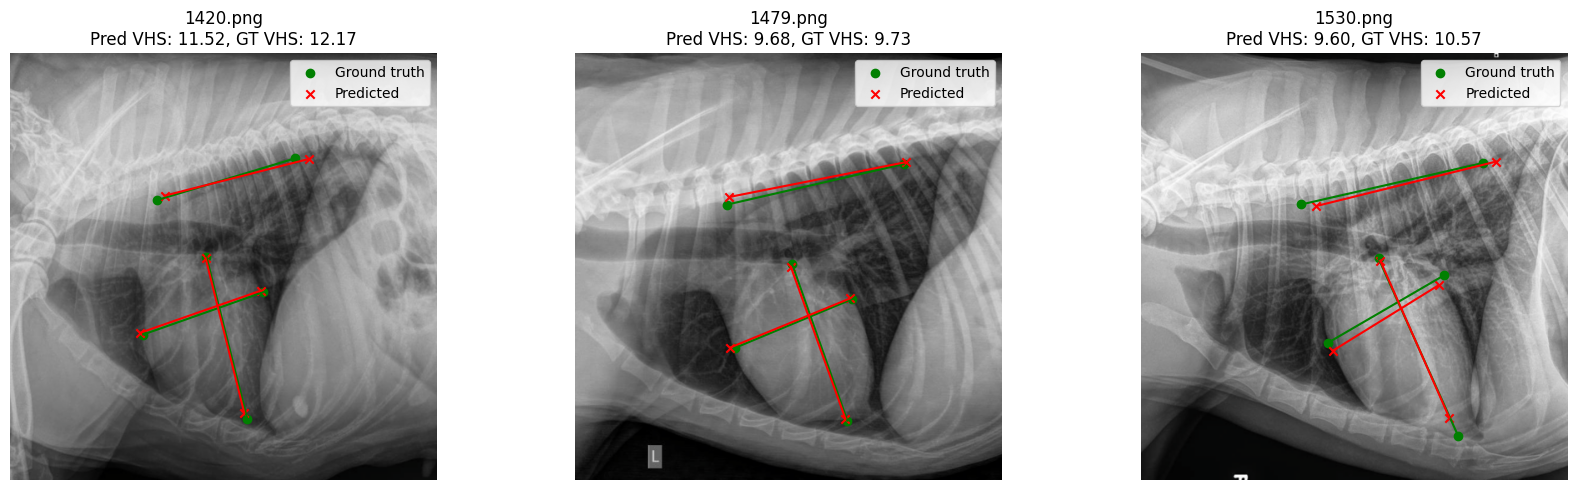

In [38]:
def draw_vhs_predictions(model, dataset, image_names, device):
    model.eval()
    fig, axes = plt.subplots(1, len(image_names), figsize=(20, 5))

    for i, image_name in enumerate(image_names):
        for idx in range(len(dataset)):
            img, points, img_name = dataset[idx]
            if img_name == image_name:
                img_tensor = img.unsqueeze(0).to(device)
                gt_points = points.cpu().numpy().reshape(-1, 2)
                gt_vhs = calculate_vhs(points)

                with torch.no_grad():
                    output = model(img_tensor)
                    if isinstance(output, tuple):
                        output = output[0]

                output = output.squeeze(0).cpu().numpy().reshape(-1, 2)
                pred_vhs = calculate_vhs(torch.tensor(output).flatten())

                img_np = img.permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                img_np = img_np.astype(np.uint8)

                ax = axes[i]
                ax.imshow(img_np)
                ax.scatter(gt_points[:, 0] * img_np.shape[1], gt_points[:, 1] * img_np.shape[0], c='g', marker='o', label='Ground truth')
                ax.scatter(output[:, 0] * img_np.shape[1], output[:, 1] * img_np.shape[0], c='r', marker='x', label='Predicted')

                # Draw lines for ground truth points
                for j in range(0, len(gt_points), 2):
                    ax.plot([gt_points[j, 0] * img_np.shape[1], gt_points[j+1, 0] * img_np.shape[1]],
                            [gt_points[j, 1] * img_np.shape[0], gt_points[j+1, 1] * img_np.shape[0]], 'g')

                for j in range(0, len(output), 2):
                    ax.plot([output[j, 0] * img_np.shape[1], output[j+1, 0] * img_np.shape[1]],
                            [output[j, 1] * img_np.shape[0], output[j+1, 1] * img_np.shape[0]], 'r')

                ax.set_title(f'{image_name}\nPred VHS: {pred_vhs:.2f}, GT VHS: {gt_vhs:.2f}')
                ax.legend()
                ax.axis('off')

                plt.tight_layout()

    plt.show()


# Specify images to visualize
image_names = ['1420.png', '1479.png', '1530.png']

# Visualize predictions
draw_vhs_predictions(model, dataset_val, image_names, device)


# ResearchGate paper link for Object Detection

https://www.researchgate.net/publication/382527444_CNN_Model_for_Key_Point_Detection_in_Canine_Cardiomegaly